In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
np.bool = np.bool_

In [3]:
!pip install --upgrade gluonts
!pip install --upgrade mxnet==1.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [4]:
import gluonts
from gluonts.dataset.common import ListDataset
import mxnet as mx
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
#import os

#!pip install wandb

In [6]:
from datetime import datetime, timedelta


In [7]:
df = pd.read_csv('/content/drive/My Drive/internship/df_ref2.csv')
df.head()

utc_timestamp        cet_cest_timestamp  \
0  2014-12-11 17:45:00  2014-12-11T18:45:00+0100   
1  2014-12-11 18:00:00  2014-12-11T19:00:00+0100   
2  2014-12-11 18:15:00  2014-12-11T19:15:00+0100   
3  2014-12-11 18:30:00  2014-12-11T19:30:00+0100   
4  2014-12-11 18:45:00  2014-12-11T19:45:00+0100   

   DE_KN_industrial3_refrigerator  DE_KN_residential3_refrigerator  \
0                             NaN                              NaN   
1                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
4                             NaN                              NaN   

   DE_KN_residential4_refrigerator  DE_KN_residential5_refrigerator  year  \
0                              NaN                              NaN  2014   
1                              NaN                              NaN  2014   
2                              NaN                              NaN  2014   
3                              NaN                              NaN  2014   
4                              NaN                              NaN  2014   

   weekofyear  dayofweek  month  hour  quarter  
0          50          4     12    17        4  
1          50          4     12    18        1  
2          50          4     12    18        2  
3          50          4     12    18        3  
4          50          4     12    18        4

In [8]:
columns_to_process_ref = [
    'DE_KN_industrial3_refrigerator',
    'DE_KN_residential3_refrigerator',
    'DE_KN_residential4_refrigerator',
    'DE_KN_residential5_refrigerator'
]

for column in columns_to_process_ref:
    if column in df.columns:
        # Create a temporary DataFrame for the current column
        temp_df = df[['utc_timestamp', column]].dropna().copy()

        # Calculate daily values
        temp_df['daily_' + column] = temp_df[column].diff()

        # Handle the first daily value
        temp_df.loc[temp_df.index[0], 'daily_' + column] = temp_df.loc[temp_df.index[0], column]

        # Merge the new daily values back into the original DataFrame
        df = df.merge(temp_df[['utc_timestamp', 'daily_' + column]], on='utc_timestamp')

df.head()

utc_timestamp        cet_cest_timestamp  \
0  2015-10-26 11:30:00  2015-10-26T12:30:00+0100   
1  2015-10-26 11:45:00  2015-10-26T12:45:00+0100   
2  2015-10-26 12:00:00  2015-10-26T13:00:00+0100   
3  2015-10-26 12:15:00  2015-10-26T13:15:00+0100   
4  2015-10-26 12:30:00  2015-10-26T13:30:00+0100   

   DE_KN_industrial3_refrigerator  DE_KN_residential3_refrigerator  \
0                           4.928                          127.624   
1                           4.933                          127.631   
2                           4.955                          127.644   
3                           4.965                          127.654   
4                           4.966                          127.654   

   DE_KN_residential4_refrigerator  DE_KN_residential5_refrigerator  year  \
0                            4.474                            0.000  2015   
1                            4.474                            0.000  2015   
2                            4.474                            0.001  2015   
3                            4.474                            0.019  2015   
4                            4.474                            0.048  2015   

   weekofyear  dayofweek  month  hour  quarter  \
0          44          1     10    11        3   
1          44          1     10    11        4   
2          44          1     10    12        1   
3          44          1     10    12        2   
4          44          1     10    12        3   

   daily_DE_KN_industrial3_refrigerator  \
0                                 0.001   
1                                 0.005   
2                                 0.022   
3                                 0.010   
4                                 0.001   

   daily_DE_KN_residential3_refrigerator  \
0                                  0.001   
1                                  0.007   
2                                  0.013   
3                                  0.010   
4                                  0.000   

   daily_DE_KN_residential4_refrigerator  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   daily_DE_KN_residential5_refrigerator  
0                                  0.000  
1                                  0.000  
2                                  0.001  
3                                  0.018  
4                                  0.029

In [9]:
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df.head()

cet_cest_timestamp  DE_KN_industrial3_refrigerator  \
utc_timestamp                                                                   
2015-10-26 11:30:00  2015-10-26T12:30:00+0100                           4.928   
2015-10-26 11:45:00  2015-10-26T12:45:00+0100                           4.933   
2015-10-26 12:00:00  2015-10-26T13:00:00+0100                           4.955   
2015-10-26 12:15:00  2015-10-26T13:15:00+0100                           4.965   
2015-10-26 12:30:00  2015-10-26T13:30:00+0100                           4.966   

                     DE_KN_residential3_refrigerator  \
utc_timestamp                                          
2015-10-26 11:30:00                          127.624   
2015-10-26 11:45:00                          127.631   
2015-10-26 12:00:00                          127.644   
2015-10-26 12:15:00                          127.654   
2015-10-26 12:30:00                          127.654   

                     DE_KN_residential4_refrigerator  \
utc_timestamp                                          
2015-10-26 11:30:00                            4.474   
2015-10-26 11:45:00                            4.474   
2015-10-26 12:00:00                            4.474   
2015-10-26 12:15:00                            4.474   
2015-10-26 12:30:00                            4.474   

                     DE_KN_residential5_refrigerator  year  weekofyear  \
utc_timestamp                                                            
2015-10-26 11:30:00                            0.000  2015          44   
2015-10-26 11:45:00                            0.000  2015          44   
2015-10-26 12:00:00                            0.001  2015          44   
2015-10-26 12:15:00                            0.019  2015          44   
2015-10-26 12:30:00                            0.048  2015          44   

                     dayofweek  month  hour  quarter  \
utc_timestamp                                          
2015-10-26 11:30:00          1     10    11        3   
2015-10-26 11:45:00          1     10    11        4   
2015-10-26 12:00:00          1     10    12        1   
2015-10-26 12:15:00          1     10    12        2   
2015-10-26 12:30:00          1     10    12        3   

                     daily_DE_KN_industrial3_refrigerator  \
utc_timestamp                                               
2015-10-26 11:30:00                                 0.001   
2015-10-26 11:45:00                                 0.005   
2015-10-26 12:00:00                                 0.022   
2015-10-26 12:15:00                                 0.010   
2015-10-26 12:30:00                                 0.001   

                     daily_DE_KN_residential3_refrigerator  \
utc_timestamp                                                
2015-10-26 11:30:00                                  0.001   
2015-10-26 11:45:00                                  0.007   
2015-10-26 12:00:00                                  0.013   
2015-10-26 12:15:00                                  0.010   
2015-10-26 12:30:00                                  0.000   

                     daily_DE_KN_residential4_refrigerator  \
utc_timestamp                                                
2015-10-26 11:30:00                                    0.0   
2015-10-26 11:45:00                                    0.0   
2015-10-26 12:00:00                                    0.0   
2015-10-26 12:15:00                                    0.0   
2015-10-26 12:30:00                                    0.0   

                     daily_DE_KN_residential5_refrigerator  
utc_timestamp                                               
2015-10-26 11:30:00                                  0.000  
2015-10-26 11:45:00                                  0.000  
2015-10-26 12:00:00                                  0.001  
2015-10-26 12:15:00                                  0.018  
2015-10-26 12:30:00                                  0.029

In [10]:
df = df.drop(columns= ['cet_cest_timestamp','DE_KN_industrial3_refrigerator',	'DE_KN_residential3_refrigerator'	,'DE_KN_residential4_refrigerator',	'DE_KN_residential5_refrigerator',	'year'	,'weekofyear',	'dayofweek'	,'month',	'hour',	'quarter'], axis = 1)
df.head()

daily_DE_KN_industrial3_refrigerator  \
utc_timestamp                                               
2015-10-26 11:30:00                                 0.001   
2015-10-26 11:45:00                                 0.005   
2015-10-26 12:00:00                                 0.022   
2015-10-26 12:15:00                                 0.010   
2015-10-26 12:30:00                                 0.001   

                     daily_DE_KN_residential3_refrigerator  \
utc_timestamp                                                
2015-10-26 11:30:00                                  0.001   
2015-10-26 11:45:00                                  0.007   
2015-10-26 12:00:00                                  0.013   
2015-10-26 12:15:00                                  0.010   
2015-10-26 12:30:00                                  0.000   

                     daily_DE_KN_residential4_refrigerator  \
utc_timestamp                                                
2015-10-26 11:30:00                                    0.0   
2015-10-26 11:45:00                                    0.0   
2015-10-26 12:00:00                                    0.0   
2015-10-26 12:15:00                                    0.0   
2015-10-26 12:30:00                                    0.0   

                     daily_DE_KN_residential5_refrigerator  
utc_timestamp                                               
2015-10-26 11:30:00                                  0.000  
2015-10-26 11:45:00                                  0.000  
2015-10-26 12:00:00                                  0.001  
2015-10-26 12:15:00                                  0.018  
2015-10-26 12:30:00                                  0.029

In [11]:
columns_to_forecast = [
    'daily_DE_KN_industrial3_refrigerator',
    'daily_DE_KN_residential3_refrigerator',
    'daily_DE_KN_residential4_refrigerator',
    'daily_DE_KN_residential5_refrigerator'
]

In [12]:
start_date = df.index.min() + pd.DateOffset(months=13)
filtered_df = df[df.index >= start_date]


In [13]:
last_timestamp = filtered_df.index.max()
few_days_ago = last_timestamp - pd.DateOffset(days=15)

train_df = filtered_df[filtered_df.index < few_days_ago]
validation_df = filtered_df[filtered_df.index >= few_days_ago]

train_list = ListDataset(
    [{"start": train_df.index[0], "target": train_df[col].values, "item_id": col} for col in columns_to_forecast],
    freq="15min"
)

validation_list = ListDataset(
    [{"start": validation_df.index[0], "target": validation_df[col].values, "item_id": col} for col in columns_to_forecast],
    freq="15min"
)

context_length = 5 * 24 * 4  # 5 days worth of 15-minute intervals
prediction_length = 5 * 24 * 4  # 5 days worth of 15-minute intervals


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2337 entries, 2016-11-26 11:30:00 to 2016-12-20 19:30:00
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   daily_DE_KN_industrial3_refrigerator   2337 non-null   float64
 1   daily_DE_KN_residential3_refrigerator  2337 non-null   float64
 2   daily_DE_KN_residential4_refrigerator  2337 non-null   float64
 3   daily_DE_KN_residential5_refrigerator  2337 non-null   float64
dtypes: float64(4)
memory usage: 91.3 KB


In [15]:
filtered_df.head()

daily_DE_KN_industrial3_refrigerator  \
utc_timestamp                                               
2016-11-26 11:30:00                                 0.017   
2016-11-26 11:45:00                                 0.016   
2016-11-26 12:00:00                                 0.016   
2016-11-26 12:15:00                                 0.016   
2016-11-26 12:30:00                                 0.017   

                     daily_DE_KN_residential3_refrigerator  \
utc_timestamp                                                
2016-11-26 11:30:00                                  0.002   
2016-11-26 11:45:00                                  0.000   
2016-11-26 12:00:00                                  0.000   
2016-11-26 12:15:00                                  0.007   
2016-11-26 12:30:00                                  0.012   

                     daily_DE_KN_residential4_refrigerator  \
utc_timestamp                                                
2016-11-26 11:30:00                                  0.000   
2016-11-26 11:45:00                                  0.001   
2016-11-26 12:00:00                                  0.000   
2016-11-26 12:15:00                                  0.013   
2016-11-26 12:30:00                                  0.015   

                     daily_DE_KN_residential5_refrigerator  
utc_timestamp                                               
2016-11-26 11:30:00                                  0.001  
2016-11-26 11:45:00                                  0.023  
2016-11-26 12:00:00                                  0.029  
2016-11-26 12:15:00                                  0.028  
2016-11-26 12:30:00                                  0.015

In [16]:
# Train the model
estimator = DeepAREstimator(
    freq="15min",
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(epochs=5)
)

predictor = estimator.train(training_data=train_list)

100%|██████████| 50/50 [01:33<00:00,  1.88s/it, epoch=5/5, avg_epoch_loss=-4.56]


In [17]:
# Make predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=validation_list,
    predictor=predictor,
    num_samples=100
)

# Convert predictions to list
forecasts = list(forecast_it)
tss = list(ts_it)

In [18]:
import json
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 4it [00:00, 73.03it/s]

{
    "MSE": 8.467586982684831e-05,
    "abs_error": 14.602914094924927,
    "abs_target_sum": 11.665000200271606,
    "abs_target_mean": 0.006075520937641462,
    "seasonal_error": 0.006841618890707203,
    "MASE": 1.284886740693189,
    "MAPE": 1.3644019660558897,
    "sMAPE": 1.3045351346333822,
    "MSIS": 5.895628271219122,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 4.838496640822905,
    "Coverage[0.1]": 0.3213541666666667,
    "QuantileLoss[0.5]": 14.602913844526483,
    "Coverage[0.5]": 0.6359375,
    "QuantileLoss[0.9]": 6.531045593507587,
    "Coverage[0.9]": 0.8484375000000001,
    "RMSE": 0.009201949240614639,
    "NRMSE": 1.5145942767809581,
    "ND": 1.2518571662420472,
    "wQuantileLoss[0.1]": 0.4147875317404835,
    "wQuantileLoss[0.5]": 1.2518571447762574,
    "wQuantileLoss[0.9]": 0.5598838818155801,
    "mean_absolute_QuantileLoss": 8.65748535961899,
    "mean_wQuantileLoss": 0.7421761861107736,
    "MAE_Coverage": 0.38281250000000006,
    "OWA": 

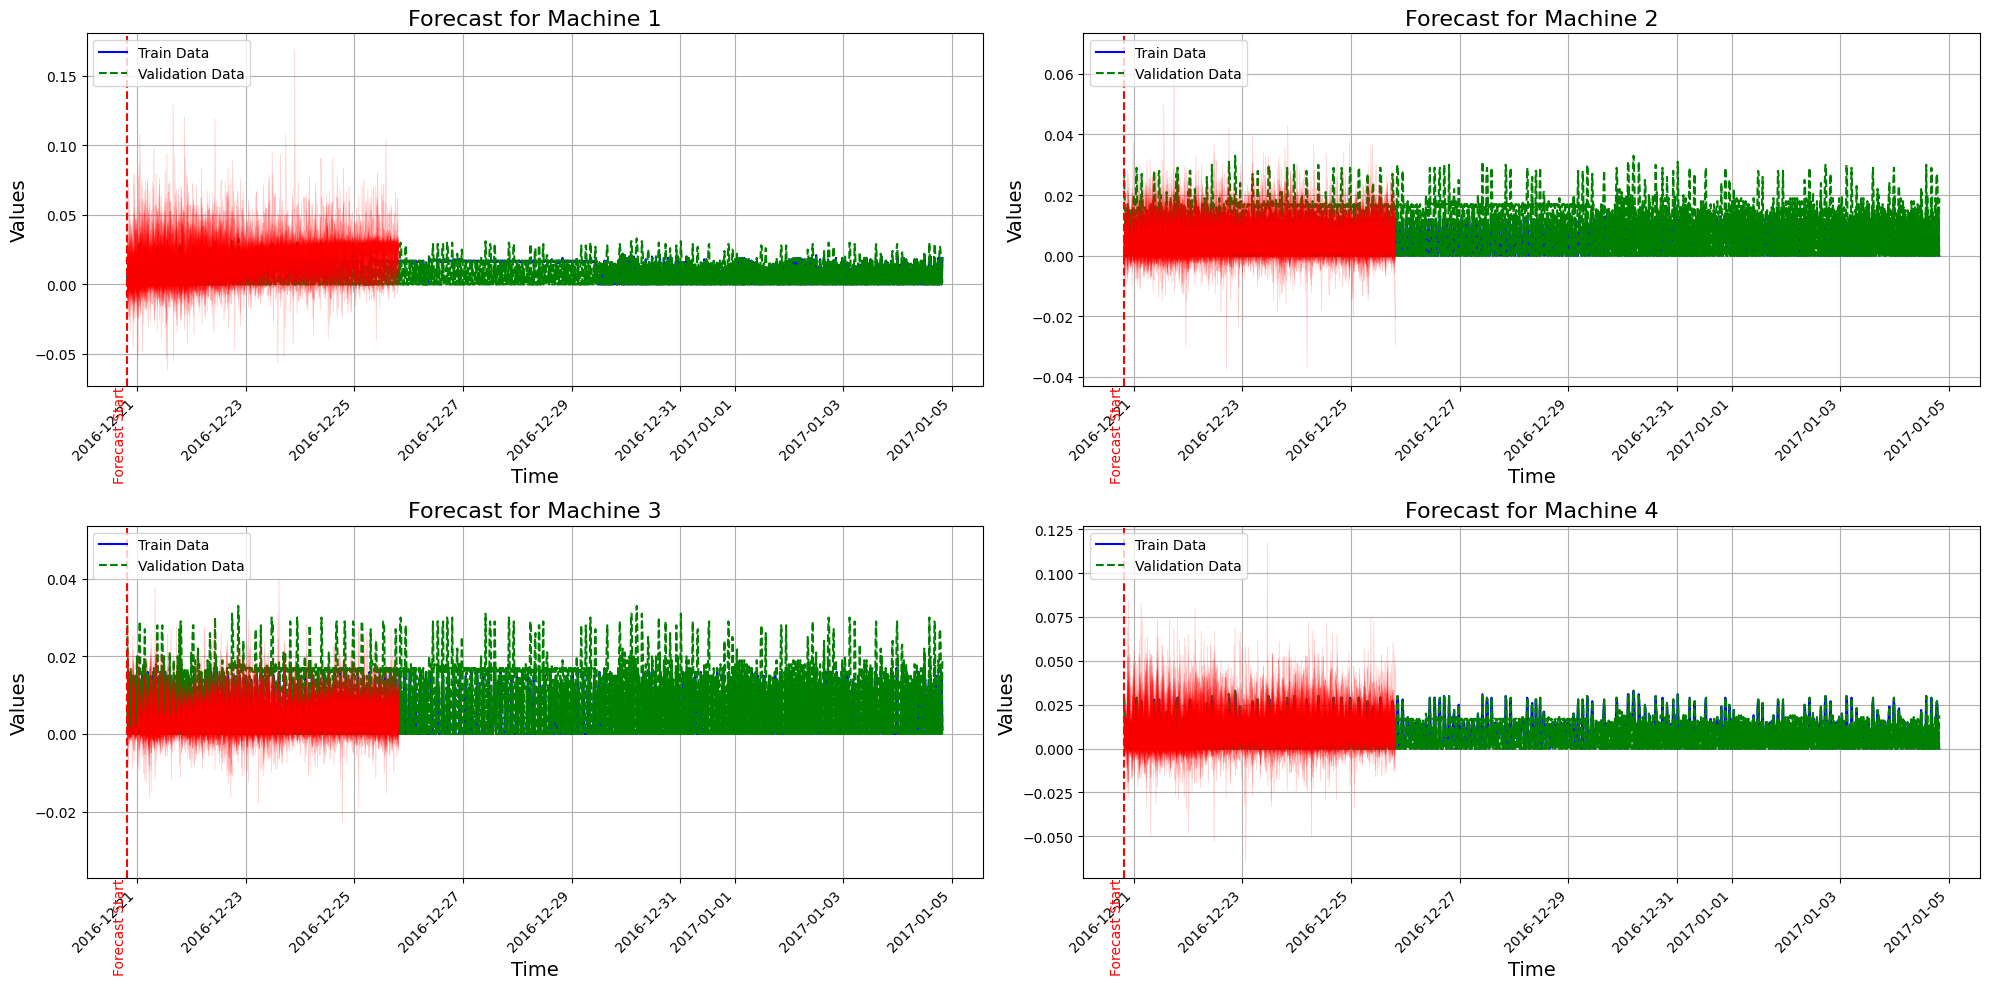

In [33]:
def plot_forecasts_with_validation(ts_entries, forecast_entries, validation_entries, forecast_length=24):

    num_plots = len(ts_entries)
    num_rows = int(np.ceil(num_plots / 2))
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx >= num_plots:
            ax.axis('off')
            continue

        ts = ts_entries[idx]
        forecast = forecast_entries[idx]
        validation = validation_entries[idx]

        if isinstance(ts.index, pd.PeriodIndex):
            ts.index = ts.index.to_timestamp()

        forecast_start_index = ts.index[-len(validation)]
        forecast_index = pd.date_range(start=forecast_start_index, periods=len(validation), freq="15min")

        ax.plot(ts.index, ts.values, label="Train Data", color="b")

        if validation is not None:
            ax.plot(validation.index, validation.values, label="Validation Data", color="g", linestyle="--")

        for sample in forecast.samples:
            sample_index = pd.date_range(start=forecast_start_index, periods=len(sample), freq="15min")
            if len(sample_index) == len(sample):
                ax.plot(sample_index, sample, color='r', alpha=0.2, linewidth=0.5)

        ax.axvline(x=forecast_start_index, color="r", linestyle="--")

        ax.text(forecast_start_index, ts.min(), "Forecast Start", color='r', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

        ax.set_title(f"Forecast for Machine {idx + 1}", fontsize=16)
        ax.set_xlabel("Time", fontsize=14)
        ax.set_ylabel("Values", fontsize=14)

        # Avoid duplicate legends
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper left")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        ax.grid(True)

    plt.tight_layout()
    plt.show()

ts_entries = [tss[idx] for idx in range(len(tss))]
forecast_entries = [forecasts[idx] for idx in range(len(forecasts))]
validation_entries = [validation_df.loc[tss[idx].index[-len(validation_df):]] for idx in range(len(tss))]  # Adjust validation data according to your actual setup

plot_forecasts_with_validation(
    ts_entries,
    forecast_entries,
    validation_entries
)


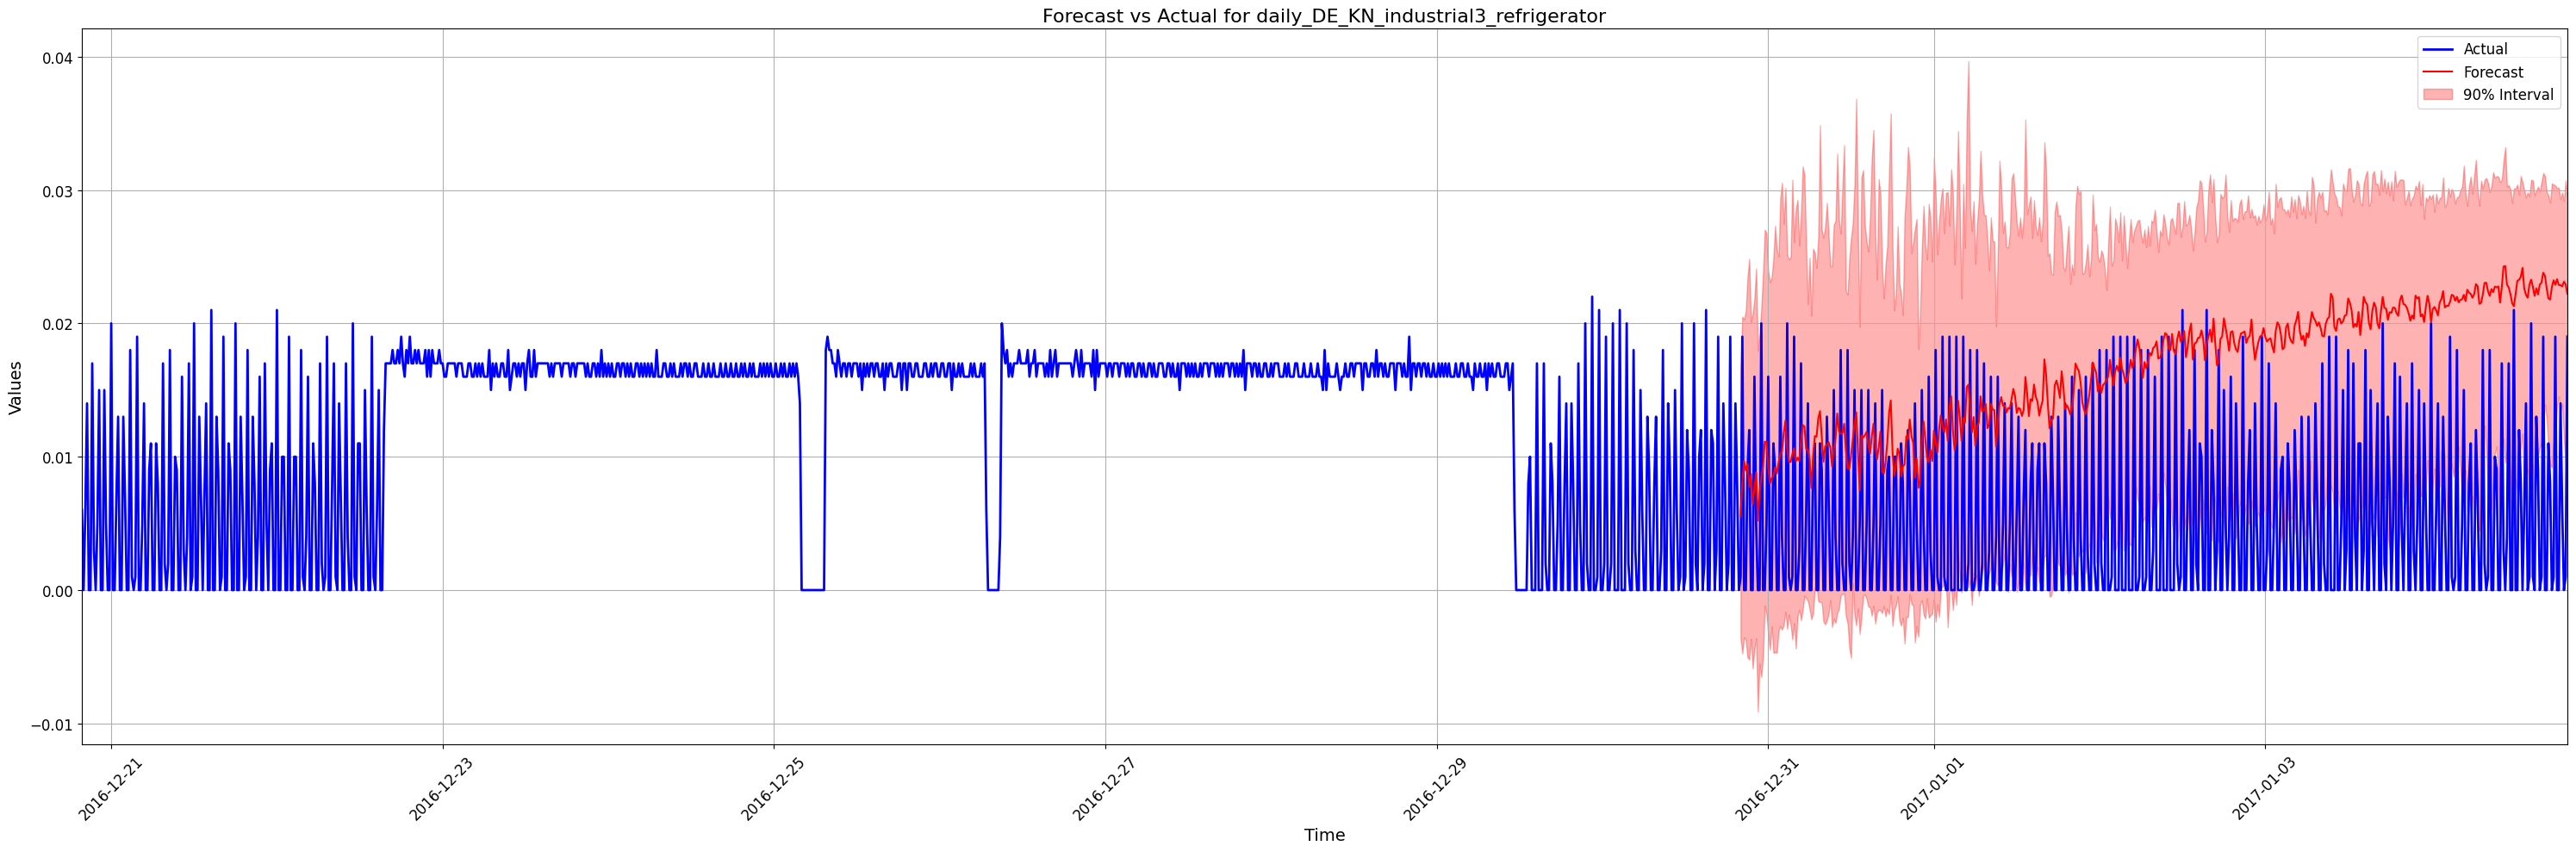

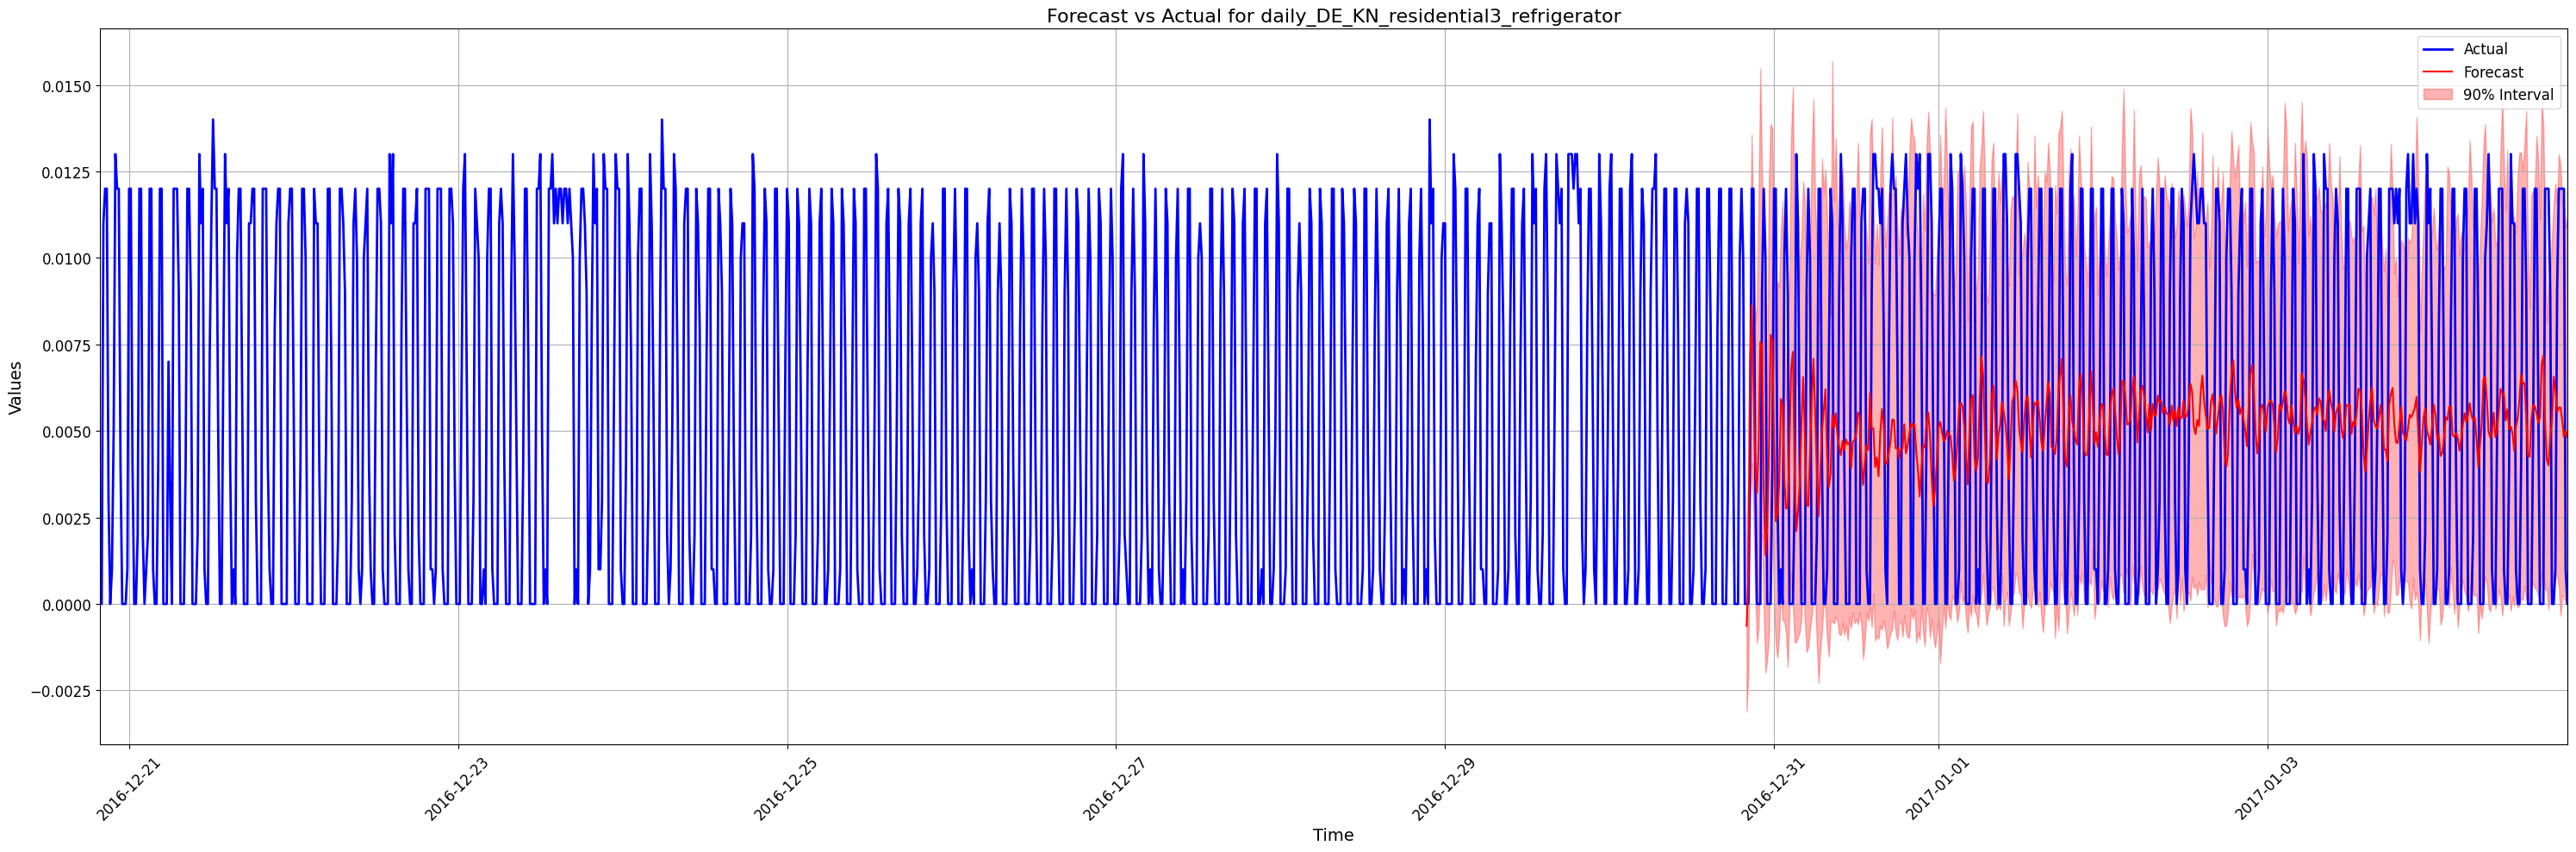

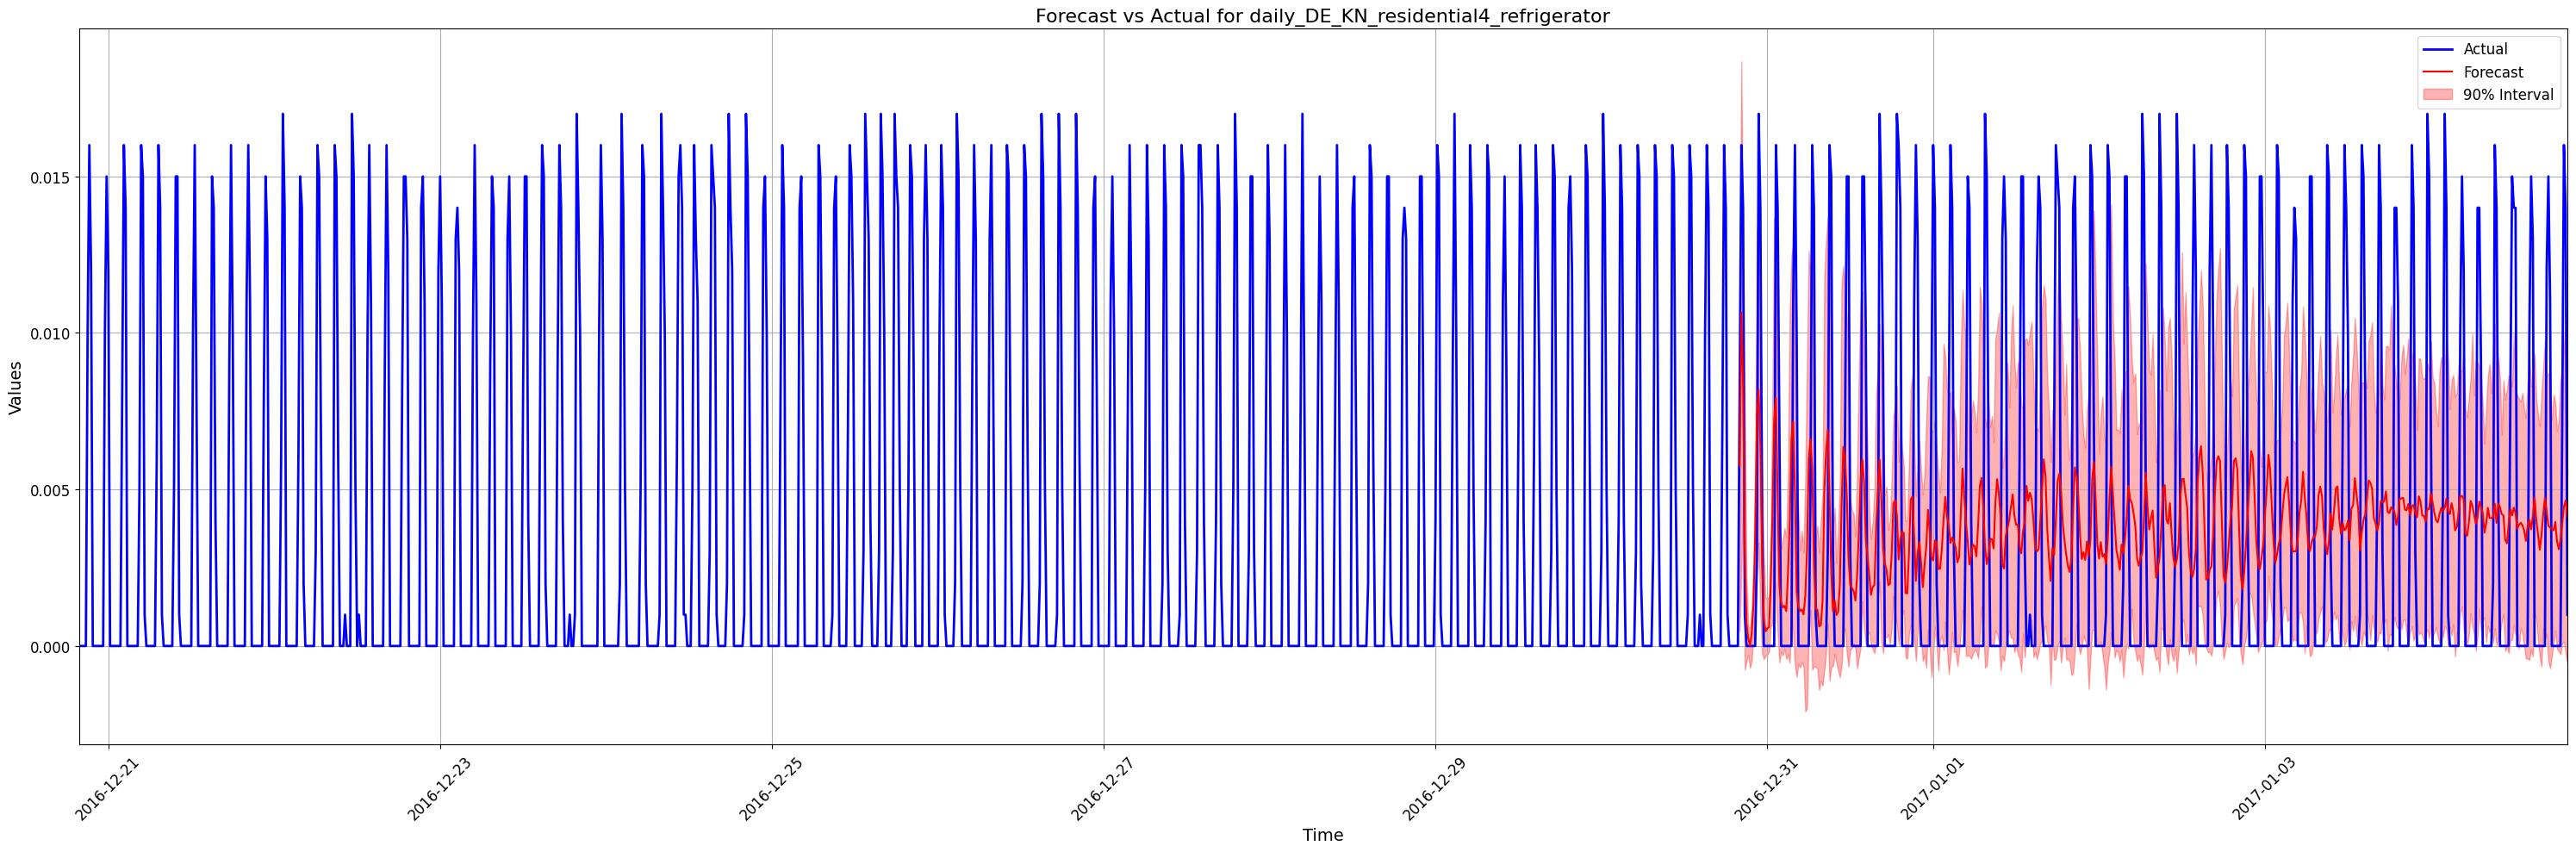

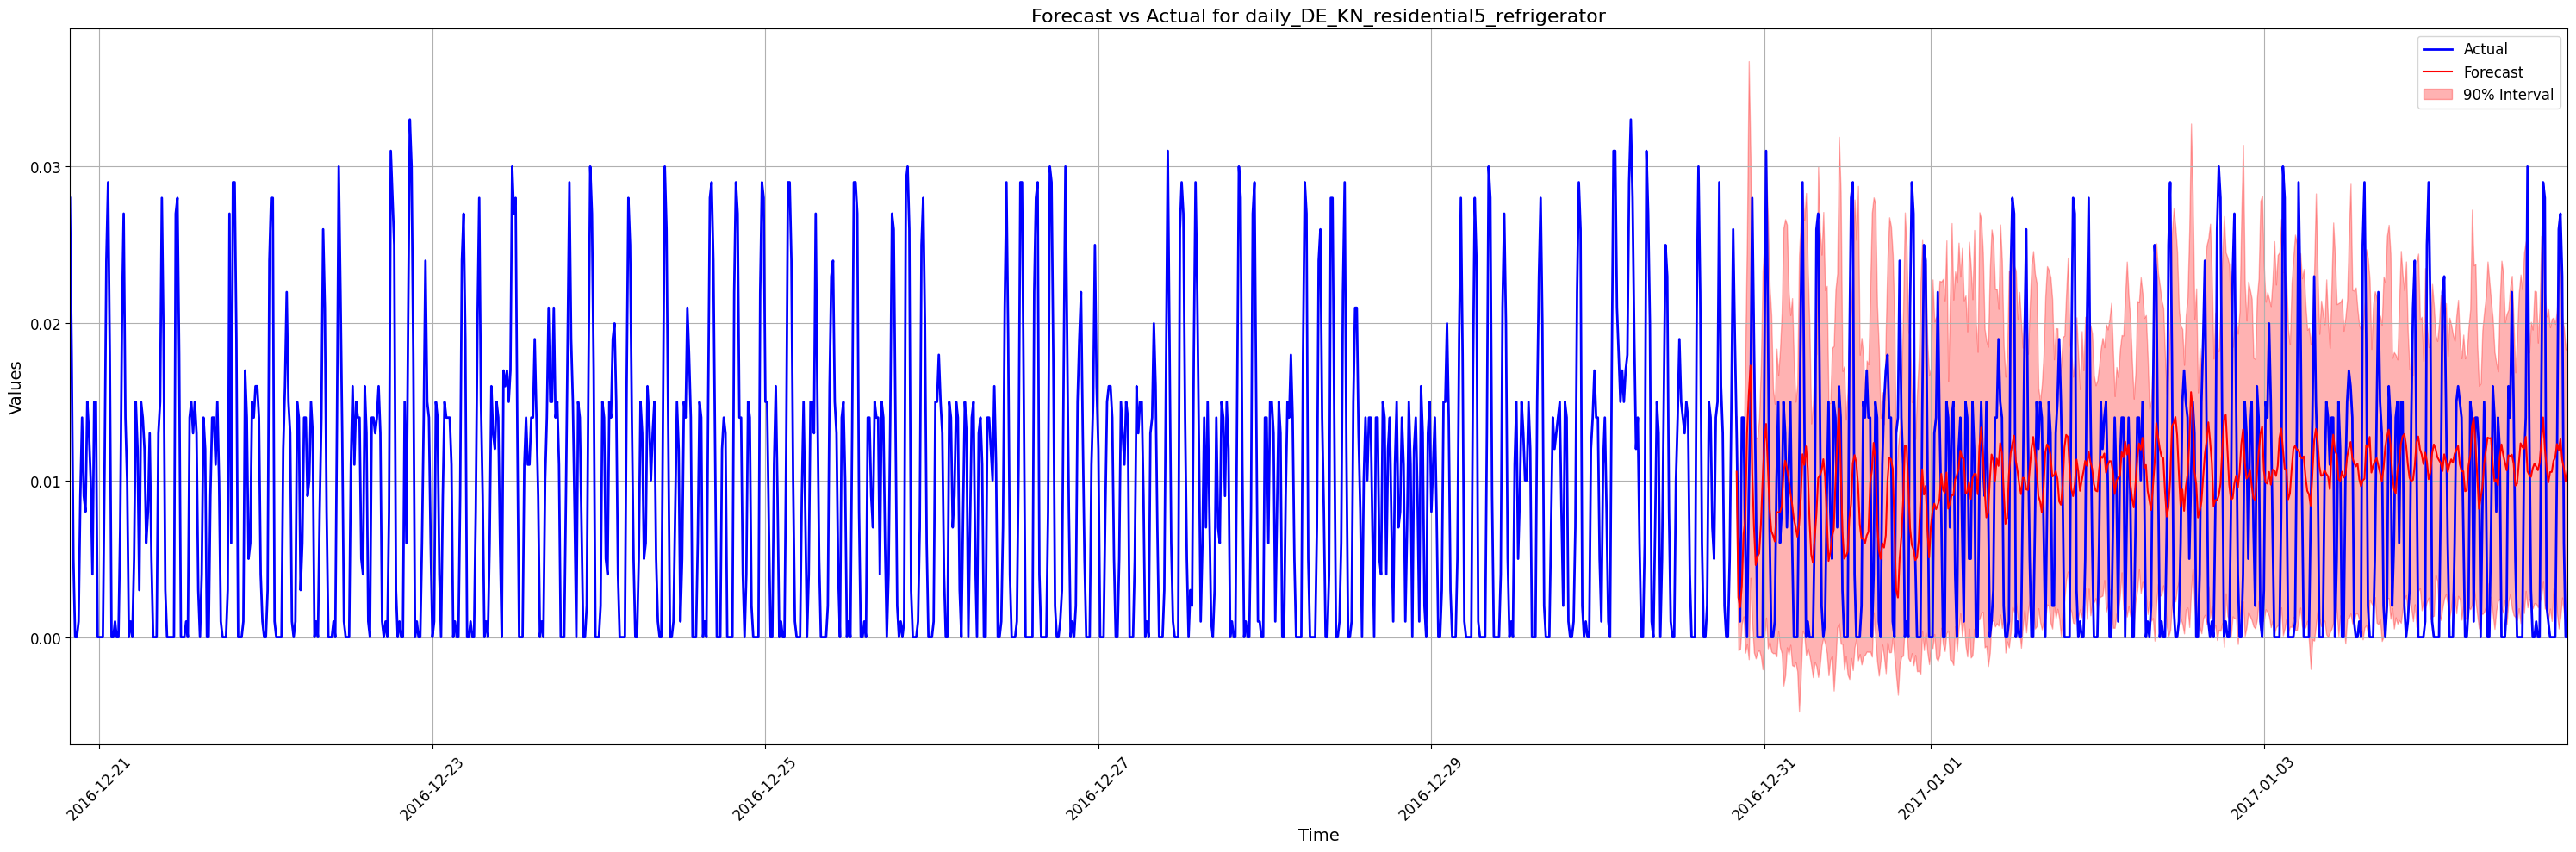

In [43]:
def plot_forecast_vs_actual(ts_entries, forecast_entries, validation_df, columns_to_forecast, forecast_length=5*24*4):
    """
    Plot forecasts against actual values for each time series.

    Parameters:
    - ts_entries: List of time series objects (pandas DataFrame or Series) for each machine.
    - forecast_entries: List of forecast objects (GluonTS forecasts) for each machine.
    - validation_df: DataFrame containing the validation data for the period to be plotted.
    - columns_to_forecast: List of column names for the time series.
    - forecast_length: Number of forecast points to plot.
    """
    for i, col in enumerate(columns_to_forecast):
        ts = ts_entries[i]
        forecast = forecast_entries[i]

        plt.figure(figsize=(30, 10))

        actual_data_length = len(validation_df)
        if len(ts) < actual_data_length:
            raise ValueError("The actual time series is shorter than the validation period.")


        ts_subset = ts[-actual_data_length:]
        plt.plot(ts_subset.index, ts_subset.values, label="Actual", linewidth=2, color='b')


        forecast_index = pd.date_range(start=ts_subset.index[-forecast_length], periods=forecast_length, freq="15min")
        if len(forecast.mean) > forecast_length:
            forecast_mean = forecast.mean[:forecast_length]
        else:
            forecast_mean = forecast.mean

        # Plot forecast median and intervals
        plt.plot(forecast_index, forecast_mean, color='r', label="Forecast")
        if forecast.quantile is not None:
            lower_interval = forecast.quantile(0.1)[:forecast_length]
            upper_interval = forecast.quantile(0.9)[:forecast_length]
            plt.fill_between(forecast_index, lower_interval, upper_interval, color='r', alpha=0.3, label="90% Interval")

        plt.title(f"Forecast vs Actual for {col}", fontsize=16)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Values", fontsize=14)
        plt.legend(fontsize=12)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlim(ts_subset.index[0], ts_subset.index[-1])

        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_forecast_vs_actual(
    tss,
    forecasts,
    validation_df,
    columns_to_forecast
)


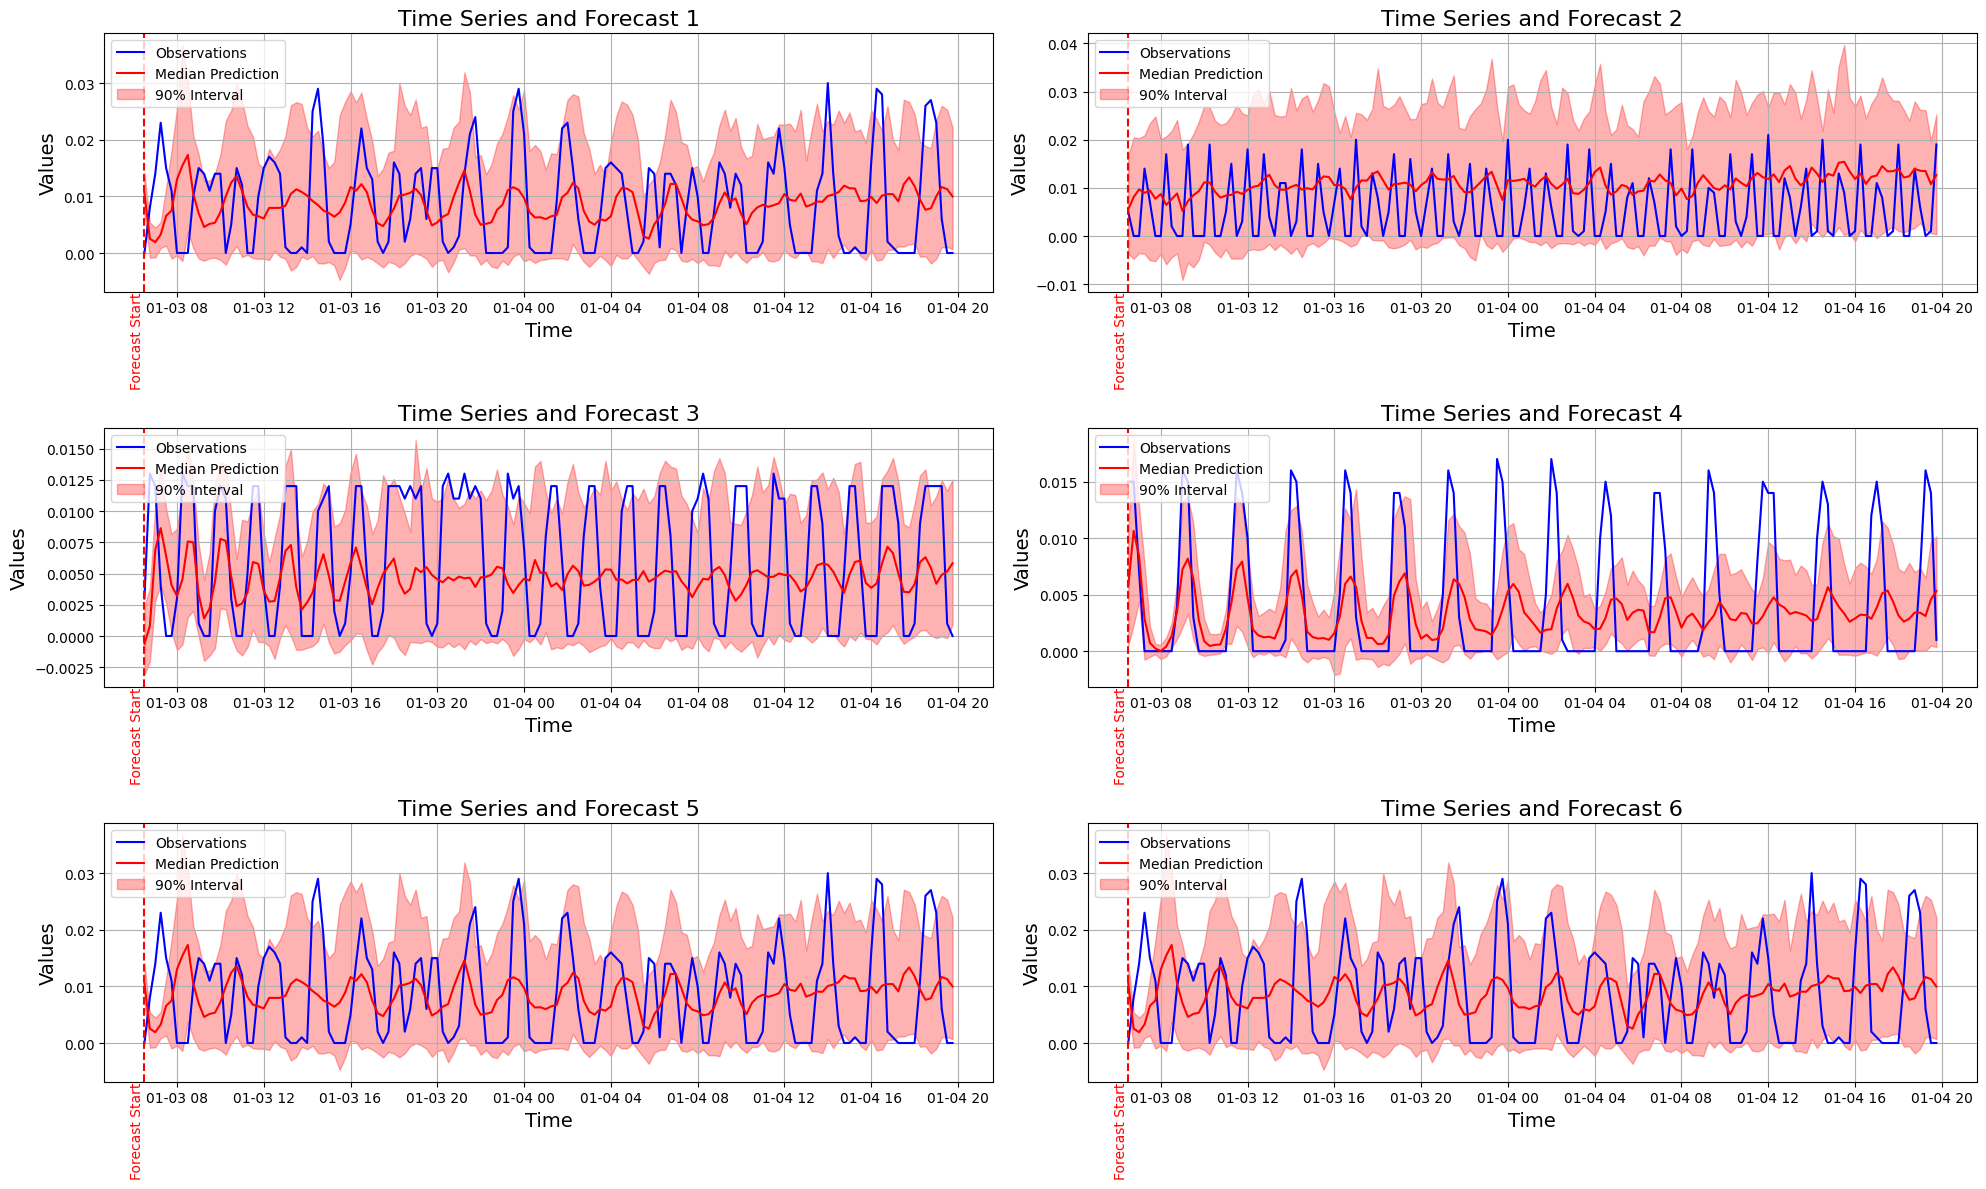

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_prob_forecasts(ts_entries, forecast_entries, plot_length=150, prediction_intervals=(50.0, 90.0)):
    """
    Plot time series with forecasted values and prediction intervals.

    Parameters:
    - ts_entries: List of time series objects (pandas DataFrame or Series).
    - forecast_entries: List of forecast objects (GluonTS forecasts).
    - plot_length: Number of points to plot.
    - prediction_intervals: Tuple of percentiles to show for prediction intervals.
    """
    fig, axes = plt.subplots(3, 2, figsize=(20, 12))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        ts = ts_entries[idx]
        forecast = forecast_entries[idx]

        # Convert PeriodIndex to DatetimeIndex if needed
        if isinstance(ts.index, pd.PeriodIndex):
            ts.index = ts.index.to_timestamp()

        # Define the prediction index
        end_index = ts.index[-1]
        prediction_index = pd.date_range(start=ts.index[-plot_length], end=end_index, freq="15min")
        forecast_length = len(prediction_index)

        # Extract median and prediction intervals from forecast
        if forecast.mean is not None:
            forecast_mean = forecast.mean
        else:
            forecast_mean = np.mean(forecast.samples, axis=0)

        # Compute prediction intervals if available
        if forecast.quantile is not None:
            lower_interval = forecast.quantile(0.1)
            upper_interval = forecast.quantile(0.9)
        else:
            # Compute intervals from samples if quantiles are not available
            lower_interval = np.percentile(forecast.samples, 10, axis=0)
            upper_interval = np.percentile(forecast.samples, 90, axis=0)

        # Ensure forecast and prediction_index are the same length
        if len(forecast_mean) != forecast_length:
            forecast_mean = forecast_mean[:forecast_length]
        if len(lower_interval) != forecast_length:
            lower_interval = lower_interval[:forecast_length]
        if len(upper_interval) != forecast_length:
            upper_interval = upper_interval[:forecast_length]

        # Plot actual time series
        ax.plot(ts.index[-plot_length:], ts[-plot_length:], label="Observations", color="b")

        # Plot forecast median
        ax.plot(prediction_index, forecast_mean, color="r", label="Median Prediction")

        # Plot forecast intervals
        ax.fill_between(prediction_index, lower_interval, upper_interval, color='r', alpha=0.3, label="90% Interval")

        # Add vertical line for forecast start
        ax.axvline(x=ts.index[-plot_length], color="r", linestyle="--")

        # Add annotation for forecast start
        ax.text(ts.index[-plot_length], ts.min(), "Forecast Start", color='r', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

        # Add labels and legend
        ax.set_title(f"Time Series and Forecast {idx + 1}", fontsize=16)
        ax.set_xlabel("Time", fontsize=14)
        ax.set_ylabel("Values", fontsize=14)
        ax.legend(loc="upper left")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Randomly select indices for plotting
np.random.seed(7)
plot_indices = [np.random.choice(len(tss)) for _ in range(6)]
ts_entries = [tss[idx] for idx in plot_indices]
forecast_entries = [forecasts[idx] for idx in plot_indices]

# Call the updated plotting function
plot_prob_forecasts(
    ts_entries,
    forecast_entries
)
